In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.dpi'] = 75

# An Introduction to Natural Language Processing

**Guest Lecturer:** Nicholas Cifuentes-Goodbody ([Twitter](https://twitter.com/ncgoodbody), [LinkedIn](https://www.linkedin.com/in/ncgoodbody/)).

## What is NLP?

Natural Language Processing (NLP) focuses on using machine learning to analyze human language. There are many differences between the **natural languages** that people use and **programming languages** that computers understand. That's why NLP tasks like voice recognition, language generation, and sentiment analysis are so challenging! 

## Our Task: Movie Review Sentiment Analysis

![Rotten Tomatoes](images/rotten-tomatoes-banner.jpg)

**What is sentiment analysis?** Sentiment analysis is when we use NLP techniques to study emotion in text or voice data. Our task today is to conduct sentiment analysis on movie reviews from [Rotten Tomatoes](https://www.rottentomatoes.com/). In this case, we'll build a model that predicts whether a reviewer feels positive or negative about a movie based on the text of their review.

**Why do sentiment analysis on movie reviews?** Production and distribution companies often adjust their advertising strategies for a film after seeing how audiences react to it. Being able to gage public sentiment in social media venues like Twitter in real time would provide an enormous advantage to these companies. This is one way sentiment analysis is  used in the private sector.

**What are the steps for doing sentiment analysis?** In today's lecture, we've broken down the process into three steps:

- **1. Import and Explore:** In order to build our model, we'll have to evaluate the characteristics of our reviews.
- **2. Preprocess:** Since we can't build a model with unstructured text data, we'll need to vectorize our dataset. 
- **Optional:** Remove *stop words* and add *n-grams*.
- **3. Build and Train:** Once we have our vectors, we'll assemble a data pipeline, train our model, and evaluate its performance.

**Did you say *vectorize*? What's that?** When you vectorize a text, you transform it into a numerical representation that is supposed to capture the meaning of the text. We'll be focusing on three strategies.

| Strategy         | Strengths                                 | Weaknesses                                                               |
| :----------------- | :---------------------------------------- | :----------------------------------------------------------------------- |
| Count   | Good for small datasets.                  | Doesn't consider text length or term frequency. Slow for large datasets. |
| TF-IDF   | Considers text length and term frequency. | Slow for large datasets.                                                 |
| Hashing | Good for large datasets.                  | Low interpretablility. Not great on small datasets.                      |

**Which Python tools will we use?** We'll use a popular machine learning library called [`scikit-learn`](http://scikit-learn.org/). Don't worry if you've never used it before. The goal of this lecture is for you to become comfortable with some of the *concepts* in NLP. This will speed up your learning when you start working with the tools.

## Step 1: Import and Explore Our Dataset

The dataset we'll use comes from [Kaggle](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data). (I've done some cleaning beforehand to speed things up.) Before we look at the data, there are a few vocabulary words that are important to know:

- **Document:** Each text that counts as an observation in our dataset. A document can be of any length — as short as a tweet or as long as book. Here, our documents will be the individual movie reviews.
- **Corpus:** The collection of documents that make up our dataset. Corpora can vary in size, but generally you'll need well over 10,000 documents to get good performance — and better to have 10 or 100 times that!

Let's import the data.

In [2]:
import pandas as pd

df = pd.read_csv('data/reviews.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2053 entries, 0 to 2052
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   document   2053 non-null   object
 1   sentiment  2053 non-null   object
dtypes: object(2)
memory usage: 32.2+ KB
None


,document,sentiment
0,a joyous occasion,pos
1,Salma goes native and she 's never been better...,pos
2,The story 's pathetic and the gags are puerile...,neg
3,The most amazing super-sized dosage of goofbal...,pos
4,Spy Kids 2 also happens to be that rarity amon...,pos


Looking at this `DataFrame`, we can see two things:

1. Our corpus is pretty small, only 2,053 documents. This will be important to remember when we decide how to build our model.
2. Our *features* (`'documents'`) and *targets* (`'sentiment'`) are in the same `DataFrame`. So the first thing we need to do is assign them to new variables, `X` and `y`.

In [3]:
X = df['document']
y = df['sentiment']

Let's create a few plots so we can get a better idea of what our targets and features look like.

Text(0.5, 1.0, 'Category Frequencies')

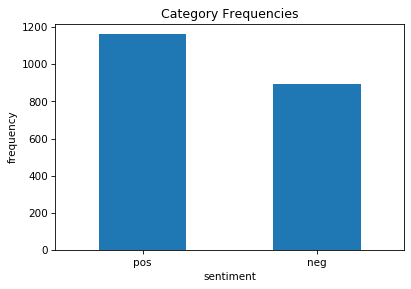

In [4]:
# Explore the targets ('sentiment')
import matplotlib.pyplot as plt

y.value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.xlabel('sentiment')
plt.ylabel('frequency')
plt.title('Category Frequencies')

Good news! The reviews are fairly evenly divided between positive and negative, so we don't need to worry about unbalanced classes. This will be important when we decide which metrics to use to evaluate our model.

Next, let's look at the text of the reviews by creating some new features.

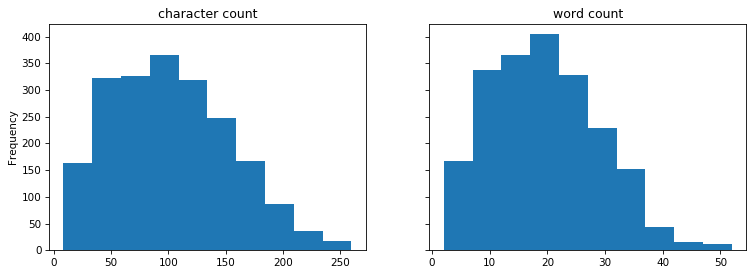

In [5]:
# Explore the features ('document')

# Create columns for character and word counts
df['char_count'] = df['document'].apply(lambda x: len(x))
df['word_count'] = df['document'].apply(lambda x: len(x.split(' ')))

# Plot our new columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
df['char_count'].plot(kind='hist', ax=ax1, title='character count')
df['word_count'].plot(kind='hist', ax=ax2, title='word count');

Here, we see that our reviews are short (about the length of a tweet). This is another important detail to consider when we build our model.

## Step 2: Preprocess Our Documents

We have a problem: The predictors in `scikit-learn` need structured, numerical data. We have unstructured, text data. 😖 This means we need to **preprocess** our reviews first, transforming them into numerical representations that we can use for training. This task is one of the most important parts of NLP.

Preprocessing generally has two steps:

1. **Tokenization:** We divide our text into discrete units called **tokens**. Usually, this means splitting the text string on the `space` character and creating a list of individual words.
2. **Vectorization:** We use our tokens to create a numerical vector of each document.

`scikit-learn` will take care of the tokenization, so we're going to focus on vectorization. There are three options in `scikit-learn` to choose from. To better see the difference between them, let's create two "mini-corpora" from our dataset that we can play with.

In [6]:
# Mini-corpus 1: Short Reviews
short_revs_idx = [312, 1307, 1143, 1699]
short_revs = X[short_revs_idx].tolist()

for n, review in enumerate(short_revs):
    print(f'doc_{n}: {review}')

doc_0: The movie is ingenious fun .
doc_1: The movie is a dud .
doc_2: This thing is virtually unwatchable .
doc_3: This thing is just garbage .


In [7]:
# Mini-corpus 2: Bad Reviews
bad_revs_ids = [1579, 2014, 1913, 1919]
bad_revs = X[bad_revs_ids].to_list()

for n, review in enumerate(bad_revs):
    print(f'doc_{n}: {review}')

doc_0: Bad movie .
doc_1: Just plain bad .
doc_2: A bad movie that happened to good actors .
doc_3: It is that rare combination of bad writing , bad direction and bad acting -- the trifecta of badness .


### `CountVectorizer`

A [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) vectorizes text by counting how many times a token appears in each document. So, in this transformation, each row in our feature matrix corresponds to a document, and each column corresponds to a token in our mini-corpus.

![CountVectorizer Animation](images/cv.gif)

I'll do this transformation first to give you a model. Pay attention because you'll have to do similar transformations later in the lecture.

In [8]:
# Import vectorizer


# Instantiate vectorizer


# Vectorize short_reviews


# Create DataFrame


# Change index labels


# Show result


,dud,fun,garbage,ingenious,is,just,movie,the,thing,this,unwatchable,virtually
doc_0,0,1,0,1,1,0,1,1,0,0,0,0
doc_1,1,0,0,0,1,0,1,1,0,0,0,0
doc_2,0,0,0,0,1,0,0,0,1,1,1,1
doc_3,0,0,1,0,1,1,0,0,1,1,0,0


A `CountVectorizer` is good for small corpora (like ours) where the documents are roughly the same size (more on that in a second). One drawback, though, is that they don't capture word order. For instance, what if we switched the words `'bad'` and `'good'` in this review?

In [9]:
print(bad_revs[2])
print(bad_revs[2][0], bad_revs[2][-13:-9], bad_revs[2][6:-14], 
      bad_revs[2][2:5], bad_revs[2][-8:])

A bad movie that happened to good actors .
A good movie that happened to bad actors .


We have two reviews that have the opposite sentiment, but the vector representations would be exactly the same because they have the same tokens.

### `TfidfVectorizer`

TF-IDF stands "term frequency, inverse document frequency". The [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) has this name because improves on the `CountVectorizer` by taking two new characteristics into account: document length and prevalence of a term within the entire corpus.

In order to see why these characteristics are important, let's look at what happens when we use a `CountVectorizer` to transform our `bad_reviews` mini-corpus.

We'll do this transformation together.

In [1]:
# Instantiate vectorizer
cv = ...

# Vectorize bad_reviews
bad_revs_trans = ...

# Create DataFrame
df_cv = ...

# Change index labels
df_cv.index = ...

# Show result
df_cv

AttributeError: 'ellipsis' object has no attribute 'index'

Let's look at one token, the term `'bad'`. For context, we'll also add word count.

In [11]:
# Add word count
df_cv['word_count'] = [len(doc.split(' ')) for doc in bad_revs]

# Filter columns
df_cv[['word_count', 'bad']]

,word_count,bad
doc_0,3,1
doc_1,4,1
doc_2,9,1
doc_3,20,3


The term `'bad'` occurs three times in `doc_3`. Does that mean that the sentiment is three times as negative? Not necessarily. `doc_3` is much longer than the other documents, so it's going to have a higher count for some terms. The `CountVecorizer` doesn't compensate for this.

And what about this review from `short_revs`:

In [12]:
print(short_revs[3])

This thing is just garbage .


In our corpus, `'garbage'` doesn't appear in many documents, and it's presence is a strong indicator of negative sentiment. In other words, the `'garbage'` token will be a helpful feature for our model.

In [13]:
df[df.document.str.contains('garbage')][['document', 'sentiment']]

,document,sentiment
198,... irritating soul-searching garbage .,neg
493,Completely creatively stillborn and executed i...,neg
1390,More of the same old garbage Hollywood has bee...,neg
1699,This thing is just garbage .,neg


But what if we had a different corpus, one full of documents about city sanitation? In that corpus, `'garbage'` would appear in nearly every document, and it's presence wouldn't be of much use to our model. Our `CountVectorizer` doesn't take this document frequency of terms into account either.

The `TfidfVectorizer` tries to solve both of these problems by starting with a word count and then applying a weighting scheme that considers both how long a document is and how common each term is in the corpus. (You can check out how the math works [here](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting).)

Let's see how TF-IDF changes the vectors for our `bad_reviews`. Try this one on your own.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Instantiate vectorizer
tfidf = ...

# Vectorize bad_revs
bad_revs_trans = ...

# Create DataFrame for display below
df_tfidf = ...

# Change index labels
df_tfidf.index = ...

# Show result
df_tfidf

,acting,actors,and,bad,badness,combination,direction,good,happened,is,...,just,movie,of,plain,rare,that,the,to,trifecta,writing
doc_0,0.00,0.00,0.00,0.55,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.83,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
doc_1,0.00,0.00,0.00,0.35,0.00,0.00,0.00,0.00,0.00,0.00,...,0.66,0.00,0.00,0.66,0.00,0.00,0.00,0.00,0.00,0.00
doc_2,0.00,0.43,0.00,0.22,0.00,0.00,0.00,0.43,0.43,0.00,...,0.00,0.34,0.00,0.00,0.00,0.34,0.00,0.43,0.00,0.00
doc_3,0.24,0.00,0.24,0.37,0.24,0.24,0.24,0.00,0.00,0.24,...,0.00,0.00,0.47,0.00,0.24,0.19,0.24,0.00,0.24,0.24


Let's look again at the term `'bad'`.

In [15]:
# Add word count
df_tfidf['word_count'] = [len(doc.split(' ')) for doc in bad_revs]

# Filter columns
df_tfidf[['word_count', 'bad']]

,word_count,bad
doc_0,3,0.55
doc_1,4,0.35
doc_2,9,0.22
doc_3,20,0.37


We see that the `'bad'` count has been down-weighted to compensate for document length. Now it looks like `doc_0` is the more negative review.

---
**Poll Question**

- We saw earlier that the `CountVectorizer` doesn't take word order into account. Does the `TfidfVectorizer` fix this problem?

---

### `HashingVectorizer`

To save time, we're not going to dive into the details of the [`HashingVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html). Here are the most important things you need to know.

- They use [feature hashing](https://en.wikipedia.org/wiki/Hash_function) to create vectors.
- Because of this, one advantage is that they're much faster than the `CountVectorizer` or `TfidfVectorizer` when working with big corpora.
- One disadvantage is that there's no way to know which columns correspond to which tokens.
- In some cases, they can hurt model performance when working with small corpora.

Here's how you use scikit-learn's HashingVectorizer. Note that we don't need to call the `fit_transform` method, just `transform`.

In [16]:
from sklearn.feature_extraction.text import HashingVectorizer

# Instantiate vectorizer
hv = HashingVectorizer(alternate_sign=False, norm=None)

# Vectorize bad_revs
bad_revs_trans = hv.transform(bad_revs).toarray()

# Create DataFrame for display below
df_hv = pd.DataFrame(bad_revs_trans)

# Change index labels
df_hv.index = [f'doc_{n}' for n in df_hv.index]

# Show result
df_hv

,0,1,2,3,4,5,6,7,8,9,...,1048566,1048567,1048568,1048569,1048570,1048571,1048572,1048573,1048574,1048575
doc_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doc_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doc_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doc_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Optional Steps 

Here are some other things you can do as part of preprocessing that can improve model performance. As we'll see, you can implement them by adding a few keyword arguments to your vectorizer.

### Remove *Stop Words*

Every language has words that are so common that they don't provide much predictive power to a model. In English, these are words like `'a'`, `'an'`, and `'the'`. Removing them during the tokenization process can improve our model. The three vectorizers we've seen have a `stop_words` argument that you can set to `'english'` and use a default list from `scikit-learn`.

In [17]:
# Instantiate vectorizer
cv = CountVectorizer(stop_words='english')

# Vectorize short_reviews
short_revs_trans = cv.fit_transform(short_revs).toarray()

# Create DataFrame
df_cv = pd.DataFrame(short_revs_trans,
                     columns=cv.get_feature_names())

# Change index labels
df_cv.index = [f'doc_{n}' for n in df_cv.index]

# Show result
df_cv

,dud,fun,garbage,ingenious,just,movie,thing,unwatchable,virtually
doc_0,0,1,0,1,0,1,0,0,0
doc_1,1,0,0,0,0,1,0,0,0
doc_2,0,0,0,0,0,0,1,1,1
doc_3,0,0,1,0,1,0,1,0,0


### Add *n-grams*

One strategy for solving the word order problem that we discussed above is to create new features for our data called **n-grams**. These are columns that correspond to *sequences of tokens*. All of the vectorizers we've seen have an `ngram_range` argument that allow us to add sequences. In this case, let's add sequences of two words — also called **bigrams** — to our data. This can improve model performance.

In [18]:
# Instantiate vectorizer
cv_ngram = CountVectorizer(ngram_range=(1,2))

# Vectorize our documents
short_revs_trans = cv_ngram.fit_transform(short_revs)

# Create DataFrame for display below
df_ngram = pd.DataFrame(short_revs_trans.toarray(),
                        columns=cv_ngram.get_feature_names())

# Format index labels and column names
df_ngram.index = [f'doc_{n}' for n in df_ngram.index]
df_ngram.columns = [col.replace(' ', '_') for col in df_ngram.columns]

# Show result
df_ngram

,dud,fun,garbage,ingenious,ingenious_fun,is,is_dud,is_ingenious,is_just,is_virtually,...,movie_is,the,the_movie,thing,thing_is,this,this_thing,unwatchable,virtually,virtually_unwatchable
doc_0,0,1,0,1,1,1,0,1,0,0,...,1,1,1,0,0,0,0,0,0,0
doc_1,1,0,0,0,0,1,1,0,0,0,...,1,1,1,0,0,0,0,0,0,0
doc_2,0,0,0,0,0,1,0,0,0,1,...,0,0,0,1,1,1,1,1,1,1
doc_3,0,0,1,0,0,1,0,0,1,0,...,0,0,0,1,1,1,1,0,0,0


## Step 3: Create Our Model

We've made it to the last step. Let's create our model! The first thing we'll do is decide as a group which vectorizer we should use.

---

**Poll Question**

- We know from our exploratory data analysis that we have a small corpus with short documents. Given this, which of the three vectorizers do you think we should use?

---

In addition to the vectorizer we've chosen, I've added some other components to the model. 

- [**`TruncatedSVD`**](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.htm): This will take the output created by the vectorizer and reduce its size in a way that often improves performance. 
- [**`GradientBoostingClassifier`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html): This predictor provides the flexibility of a decision tree but is more resistant to overfitting.

In [19]:
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

# Create pipeline
model = Pipeline([
    ('vectorizer', ...),
    ('dim_red', TruncatedSVD(n_components=50, random_state=42)),
    ('predictor', GradientBoostingClassifier(random_state=42))
])

# Fit model to training data
model.fit(X, y);

Once our model is fit, how can we evaluate its performance? One classification metric that most people know is *accuracy*. That's a good start (especially since our classes our pretty balances), but we should also look at [*precision* and *recall*](https://en.wikipedia.org/wiki/Precision_and_recall).

**One important disclaimer:** If you really want to know how your model performs, you need to split your data into [*training* and *testing* sets](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets), and then compare metrics between the two. But we're more interested in the *concepts* in this lecture rather than model performance. The truth is our corpus is so small that our model would probably not generalize well. Remember, you need tens or hundreds of thousands of reviews to have a good model. So let's not worry about the split for now.

In [20]:
from sklearn.metrics import classification_report

y_pred = model.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

         neg       0.93      0.86      0.89       892
         pos       0.90      0.95      0.92      1161

    accuracy                           0.91      2053
   macro avg       0.91      0.90      0.91      2053
weighted avg       0.91      0.91      0.91      2053



Just for fun, let's try a few reviews that I've written. Feel free to write your own. See if you can fool the model. 😉

In [21]:
test_revs = ["This movie is terrible.",
             "This movie is great.",
             "I've seen worse films.",
             "I think you should stay home instead."]

model.predict(test_revs)

array(['neg', 'pos', 'pos', 'neg'], dtype=object)

## Key Takeaways

- **Natural Language Processing** (NLP) uses machine learning to analyze human language.
- **Sentiment analysis** is when you use NLP to study emotion in text or voice data.
- In NLP, a dataset is called a **corpus**. It's comprised of **documents**.
- In order to build an NLP model, you need to **preprocess** your corpus. 
- The two steps of preprocessing are **tokenization** and **vectorization**. 
- `scikit-learn` has three vectorization options:

| Vectorizer          | Strengths                                                      | Weaknesses                                                                                                                 |
| :------------------ | :------------------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------- |
| `CountVectorizer`   | Good for small corpora where documents are of similar lengths. | Can be slow for large corpora. Doesn't consider document length or term frequency in corpus. Doesn't represent word order. |
| `TfidfVectorizer`   | Good for small corpora. Takes into account document length and term frequency in corpus.                                       | Can be slow for large corpora. Doesn't represent word order.                                                               |
| `HashingVectorizer` | Good for large corpora. Good for online learning.              | Can't explain features. Can hurt performance for small corpora. Doesn't represent word order.                              |

- You might improve your model by removing **stop words**.
- One way to represent word order is by adding **n-grams** to your features.